In [236]:
# imports

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
import re
import string
from random import randint

from nltk.corpus import stopwords
from wordcloud import STOPWORDS, WordCloud
from contractions import contractions_dict

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding, TimeDistributed
from tensorflow.keras.layers import Dot, Activation

import unicodedata
import pickle


In [290]:
from rouge import Rouge

def calculate_rouge_score(text, summary):
    rouge = Rouge()
    scores = rouge.get_scores(summary, text)
    rouge_1_recall = scores[0]['rouge-1']['f']
    rouge_2_recall = scores[0]['rouge-2']['f']
    rouge_l_recall = scores[0]['rouge-l']['f']
    return rouge_1_recall, rouge_2_recall, rouge_l_recall

Defaulting to user installation because normal site-packages is not writeable


In [237]:
tpu_strategy = tf.distribute.OneDeviceStrategy('CPU')  # Use CPU

In [238]:
filename1 = './input/news_summary.csv'

df1 = pd.read_csv(filename1, encoding='iso-8859-1').reset_index(drop=True)

In [239]:
df1.sample(5)

,author,date,headlines,read_more,text,ctext
2409,Parmeet Kaur,"14 Jul 2017,Friday",Hotel room where Sunanda Pushkar died not open...,http://www.hindustantimes.com/delhi-news/can-t...,The Delhi Police on Friday told a city court t...,The Delhi police on Friday told a city court t...
1012,Vani Vivek,"18 Jul 2017,Tuesday",PremjiInvest buys 3.26% stake in Future Lifest...,http://indiatoday.intoday.in/story/premjiinves...,"PremjiInvest, the investment arm of Wipro Chai...","New Delhi, Jul 17 (PTI) PremjiInvest, the inve..."
521,Sonu Kumari,"26 Jul 2017,Wednesday",Sacked employees damage Vivo factory in Noida,http://www.hindustantimes.com/noida/sacked-emp...,Workers of Vivo phone factory on Tuesday prote...,The workers at a mobile phone factory in Great...
3120,Rini Sinha,"05 Jun 2017,Monday",I was a fool to sign Tiger Zinda Hai: Salman Khan,http://indiatoday.intoday.in/story/salman-khan...,Actor Salman Khan has said that he has taken a...,Salman Khan is on a film-promotion spree right...
2446,Arshiya Chopra,"14 Jul 2017,Friday",GoI looking for math tutor: Rahul takes dig at...,http://www.hindustantimes.com/india-news/govt-...,Taking a dig at RBI Governor Urjit Patel on hi...,Congress Vice President Rahul Gandhi and senio...


In [240]:
df1_columns = df1.columns.tolist()
df1_columns.remove('headlines')
df1_columns.remove('text')
df1.drop(df1_columns, axis='columns', inplace=True)

df = df1

# Shuffling the df
df = df.sample(frac=1).reset_index(drop=True)

print(f'Dataset size: {len(df)}')
df.sample(5)

# Headlines column is summary

Dataset size: 4514


,headlines,text
1542,'Fearless Girl' statue stares down Wall Street...,A statue of a young girl staring down the bron...
3659,Will look at Vodafone-Idea merger when require...,Telecom regulator TRAI on Friday said it will ...
2490,Indian fisherman shot dead by Sri Lankan Navy,An Indian fisherman was shot dead on Monday by...
3023,"Salman, Aamir will run after 21-year-old heroi...","Raveena Tandon, when asked if she would like t..."
3359,"CBSE warns schools against selling books, unif...","Asserting that ""educational institutions are n..."


## Data Pre-processing

In [241]:
# Converting to lowercase
df.text = df.text.apply(str.lower)
df.headlines = df.headlines.apply(str.lower)

In [242]:
# Removing contractions
def expand_contractions(text, contraction_map=contractions_dict):
    # Using regex for getting all contracted words
    contractions_keys = '|'.join(contraction_map.keys())
    contractions_pattern = re.compile(f'({contractions_keys})', flags=re.DOTALL)

    def expand_match(contraction):
        # Getting entire matched sub-string
        match = contraction.group(0)
        expanded_contraction = contraction_map.get(match)
        if not expand_contractions:
            print(match)
            return match
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

df.headlines = df.headlines.apply(expand_contractions)
df.text = df.text.apply(expand_contractions)

In [243]:
# Remove puncuation from word
def rm_punc_from_word(word):
    clean_alphabet_list = [
        alphabet for alphabet in word if alphabet not in string.punctuation
    ]
    return ''.join(clean_alphabet_list)

# Remove puncuation from text
def rm_punc_from_text(text):
    clean_word_list = [rm_punc_from_word(word) for word in text]
    return ''.join(clean_word_list)

# Remove numbers from text
def rm_number_from_text(text):
    text = re.sub('[0-9]+', '', text)
    return ' '.join(text.split())  # to rm `extra` white space


In [244]:
# Remove stopwords from text
def rm_stopwords_from_text(text):
    _stopwords = stopwords.words('english')
    text = text.split()
    word_list = [word for word in text if word not in _stopwords]
    return ' '.join(word_list)

In [245]:
# Cleaning text
def clean_text(text):
    text = text.lower()
    text = rm_punc_from_text(text)
    text = rm_number_from_text(text)
    text = rm_stopwords_from_text(text)

    # there are hyphen(–) in many titles, so replacing it with empty str
    # this hyphen(–) is different from normal hyphen(-)
    text = re.sub('–', '', text)
    text = ' '.join(text.split())  # removing `extra` white spaces

    # Removing unnecessary characters from text
    text = re.sub("(\\t)", ' ', str(text)).lower()
    text = re.sub("(\\r)", ' ', str(text)).lower()
    text = re.sub("(\\n)", ' ', str(text)).lower()

    # remove accented chars ('Sómě Áccěntěd těxt' => 'Some Accented text')
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode(
        'utf-8', 'ignore'
    )

    text = re.sub("(__+)", ' ', str(text)).lower()
    text = re.sub("(--+)", ' ', str(text)).lower()
    text = re.sub("(~~+)", ' ', str(text)).lower()
    text = re.sub("(\+\++)", ' ', str(text)).lower()
    text = re.sub("(\.\.+)", ' ', str(text)).lower()

    text = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(text)).lower()

    text = re.sub("(mailto:)", ' ', str(text)).lower()
    text = re.sub(r"(\\x9\d)", ' ', str(text)).lower()
    text = re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(text)).lower()
    text = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM',
                  str(text)).lower()

    text = re.sub("(\.\s+)", ' ', str(text)).lower()
    text = re.sub("(\-\s+)", ' ', str(text)).lower()
    text = re.sub("(\:\s+)", ' ', str(text)).lower()
    text = re.sub("(\s+.\s+)", ' ', str(text)).lower()

    try:
        url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(text))
        repl_url = url.group(3)
        text = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', repl_url, str(text))
    except Exception as e:
        pass

    text = re.sub("(\s+)", ' ', str(text)).lower()
    text = re.sub("(\s+.\s+)", ' ', str(text)).lower()

    return text

In [246]:
df.text = df.text.apply(clean_text)
df.headlines = df.headlines.apply(clean_text)
df.sample(5)

,headlines,text
4286,govt plans penalise found guilty polluting ganga,nda government planning ganga act penalise fou...
403,killed injured myanwater festival,least people killed others injured fourday ann...
3470,woman reportedly killed dowry found living lover,yearold bihar woman reportedly killed husband ...
1366,mumbai dabbawalas celebrate icj order kulbhush...,mumbai dabbawalas today celebrated internation...
926,two trekkers found dead maharashtras devkund w...,dead bodies two trekkers went missing last wee...


In [247]:
# saving the cleaned data
df.to_csv('cleaned_data.csv')

In [248]:
# To customize colours of wordcloud texts
def wc_blue_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(214, 67%%, %d%%)" % randint(60, 100)


# stopwords for wordcloud
def get_wc_stopwords():
    wc_stopwords = set(STOPWORDS)

    # Adding words to stopwords
    # these words showed up while plotting wordcloud for text
    wc_stopwords.add('s')
    wc_stopwords.add('one')
    wc_stopwords.add('using')
    wc_stopwords.add('example')
    wc_stopwords.add('work')
    wc_stopwords.add('use')
    wc_stopwords.add('make')

    return wc_stopwords


# plot wordcloud
def plot_wordcloud(text, color_func):
    wc_stopwords = get_wc_stopwords()
    wc = WordCloud(stopwords=wc_stopwords, width=1200, height=600, random_state=0).generate(text)

    f, axs = plt.subplots(figsize=(20, 10))
    with sns.axes_style("ticks"):
        sns.despine(offset=10, trim=True)
        plt.imshow(wc.recolor(color_func=color_func, random_state=0), interpolation="bilinear")
        plt.xlabel('WordCloud')

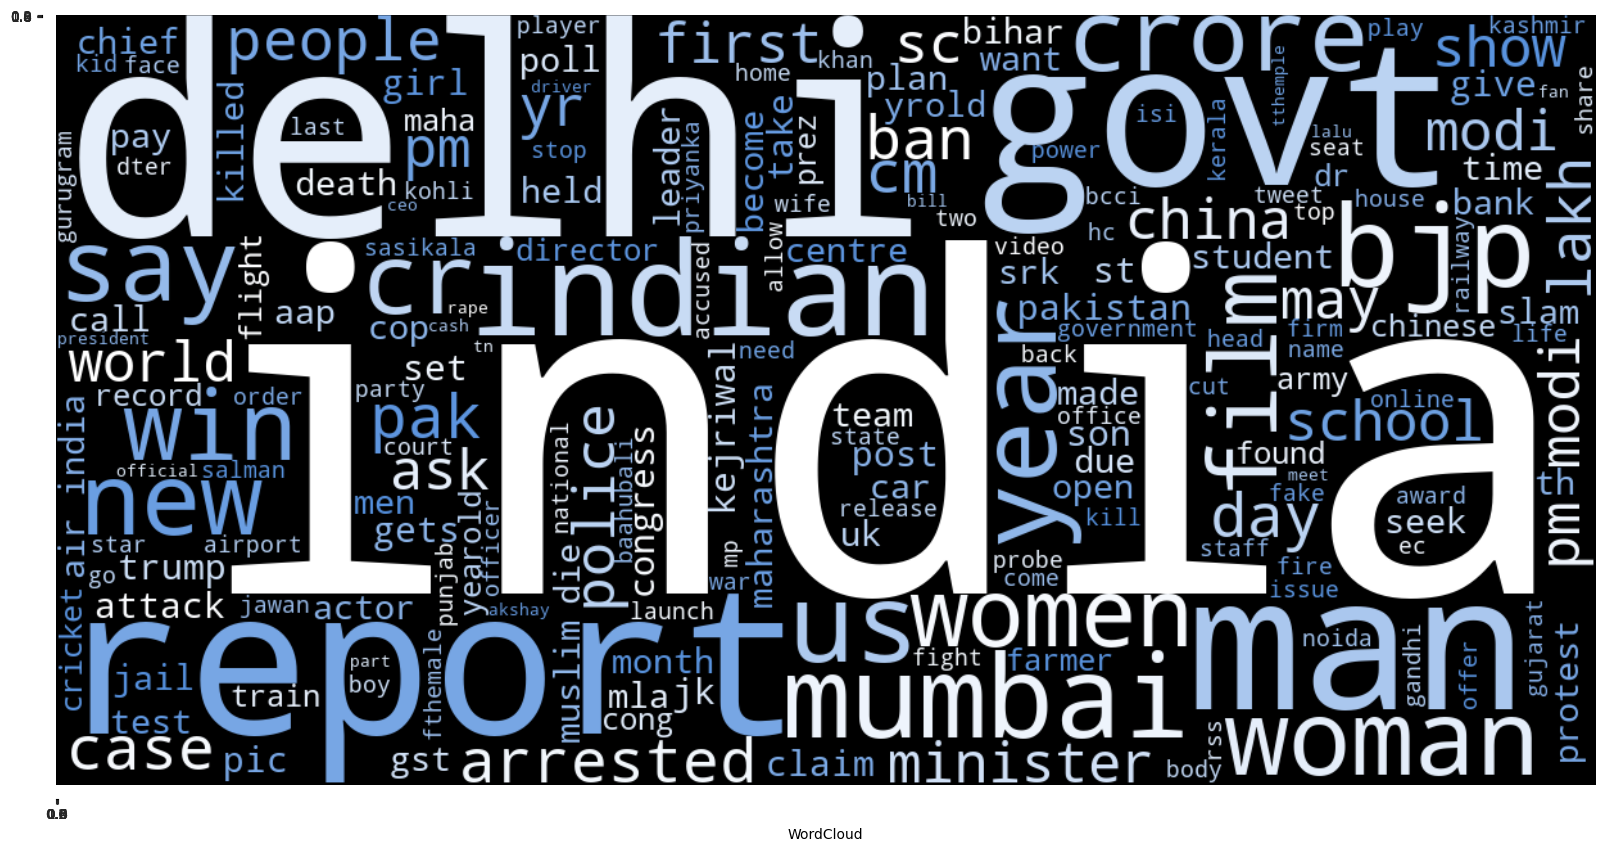

In [249]:
plot_wordcloud(' '.join(df.headlines.values.tolist()), wc_blue_color_func)

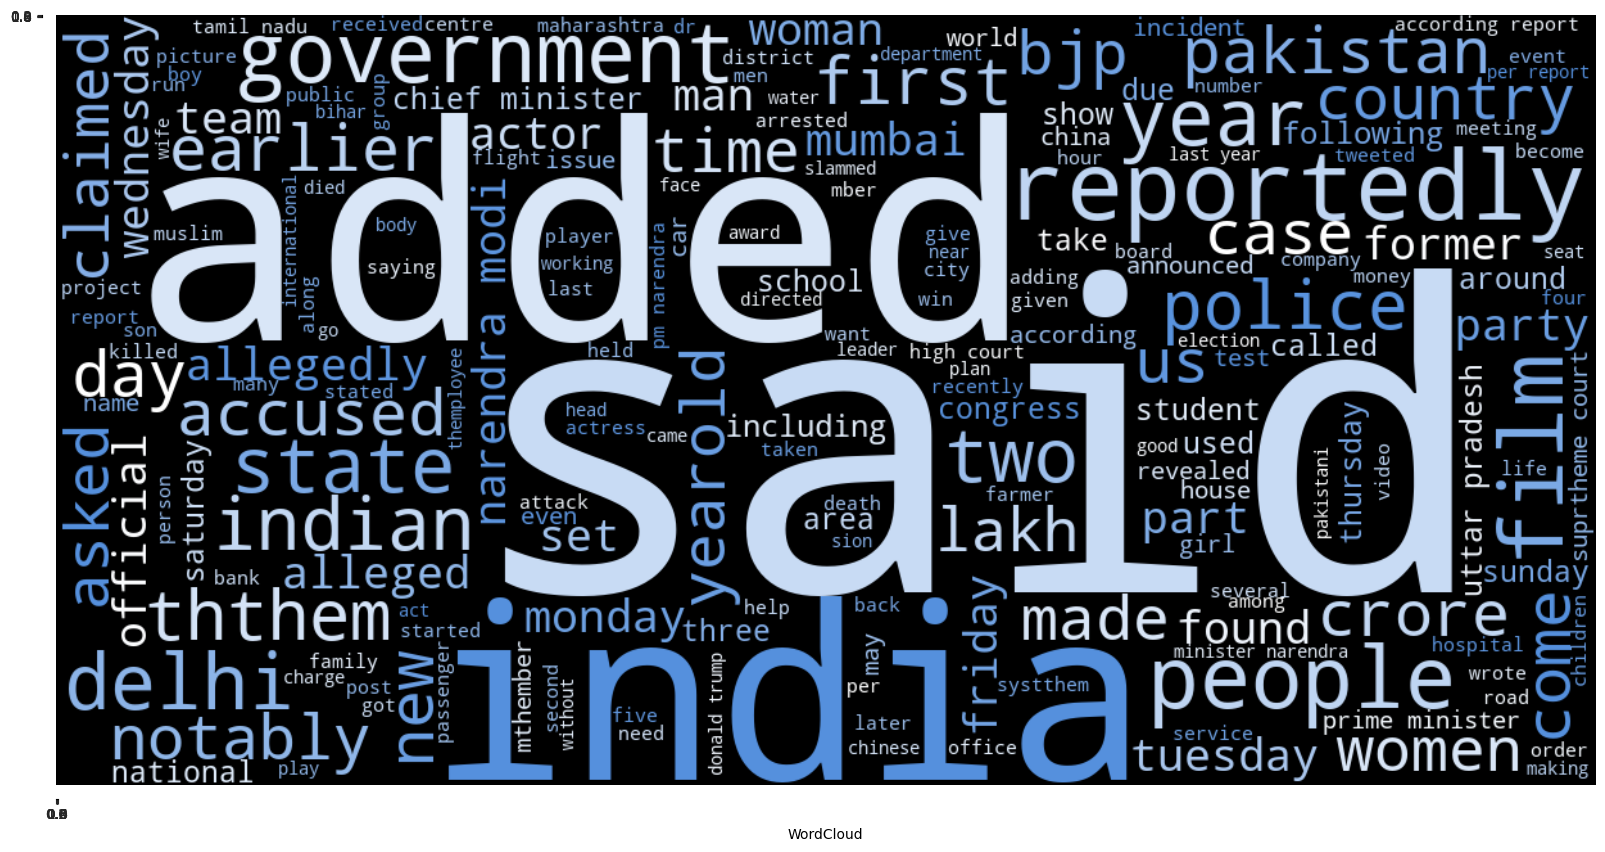

In [250]:
plot_wordcloud(' '.join(df.text.values.tolist()), wc_blue_color_func)

Adding start and end to the headlines to tell where it starts and stop

In [251]:
df.headlines = df.headlines.apply(lambda x: f'_START_ {x} _END_')

In [252]:
start_token = 'sostok'
end_token = 'eostok'
df.headlines = df.headlines.apply(lambda x: f'{start_token} {x} {end_token}')

In [253]:
df.sample(5)

,headlines,text
985,sostok _START_ woman arrested posing cancer pa...,yearold woman posed cancer patient con faceboo...
2723,sostok _START_ police personnel every lakh peo...,country police personnel secure every one lakh...
2426,sostok _START_ incredible heights fiction shra...,actress shraddha kapoor speaking reports datin...
1479,sostok _START_ lpg cylinders explode karnataka...,liquefied petroleum gas lpg cylinders stored t...
1211,sostok _START_ want settle early life says ali...,alia bhatt talking plans regarding iage said w...


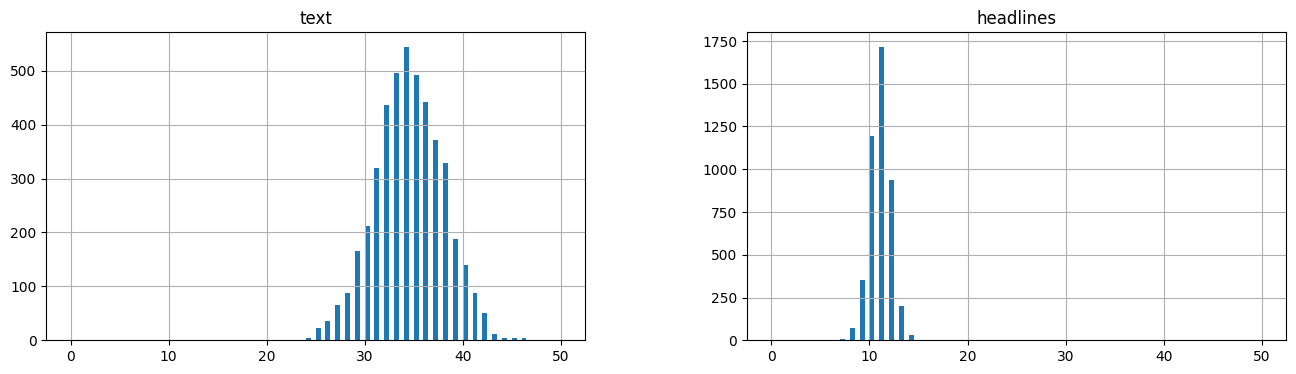

In [254]:
text_count = [len(sentence.split()) for sentence in df.text]
headlines_count = [len(sentence.split()) for sentence in df.headlines]

pd.DataFrame({'text': text_count, 'headlines': headlines_count}).hist(bins=100, figsize=(16, 4), range=[0, 50])
plt.show()

In [255]:
# To check how many rows in a column has length (of the text) <= limit
def get_word_percent(column, limit):
    count = 0
    for sentence in column:
        if len(sentence.split()) <= limit:
            count += 1

    return round(count / len(column), 2)


# Check how many % of headlines have 0-13 words
print(get_word_percent(df.headlines, 13))

# Check how many % of summary have 0-42 words
print(get_word_percent(df.text, 42))

0.99
0.99


In [256]:
max_text_len = 42
max_summary_len = 13

# select the summary and text between their defined max lens respectively
def trim_text_and_summary(df, max_text_len, max_summary_len):
    cleaned_text = np.array(df['text'])
    cleaned_summary = np.array(df['headlines'])

    short_text = []
    short_summary = []

    for i in range(len(cleaned_text)):
        if len(cleaned_text[i].split()) <= max_text_len and len(
            cleaned_summary[i].split()
        ) <= max_summary_len:
            short_text.append(cleaned_text[i])
            short_summary.append(cleaned_summary[i])

    df = pd.DataFrame({'text': short_text, 'summary': short_summary})
    return df


df = trim_text_and_summary(df, max_text_len, max_summary_len)
print(f'Dataset size: {len(df)}')
df.sample(5)

Dataset size: 4458


,text,summary
3079,one three labourers died monday trapped almost...,sostok _START_ man dies falling pit digging se...
3601,fouryearold girl died monday two days sustaini...,sostok _START_ yearold girl dies falling tea p...
3294,delhi police received complaints us online ret...,sostok _START_ us company sells beer image lor...
2199,haryanabased shweta mehta neha dhupias gang sa...,sostok _START_ haryana girl shweta mehta wins ...
2589,shiv senas ravindra gaikwad hit air india staf...,sostok _START_ shiv sena mp hit air india staf...


In [257]:
# rare word analysis
def get_rare_word_percent(tokenizer, threshold):
    # threshold: if the word's occurrence is less than this then it's rare word

    count = 0
    total_count = 0
    frequency = 0
    total_frequency = 0

    for key, value in tokenizer.word_counts.items():
        total_count += 1
        total_frequency += value
        if value < threshold:
            count += 1
            frequency += value

    return {
        'percent': round((count / total_count) * 100, 2),
        'total_coverage': round(frequency / total_frequency * 100, 2),
        'count': count,
        'total_count': total_count
    }

In [258]:
# Splitting the training and validation sets
x_train, x_val, y_train, y_val = train_test_split(
    np.array(df['text']),
    np.array(df['summary']),
    test_size=0.1,
    random_state=1,
    shuffle=True
)

### Tokenizing text

In [259]:
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))

x_tokens_data = get_rare_word_percent(x_tokenizer, 4)
print(x_tokens_data)

{'percent': 69.57, 'total_coverage': 14.38, 'count': 13553, 'total_count': 19482}


In [260]:
# save tokenizer
with open('x_tokenizer', 'wb') as f:
    pickle.dump(x_tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

In [261]:
# one-hot-encoding
x_train_sequence = x_tokenizer.texts_to_sequences(x_train)
x_val_sequence = x_tokenizer.texts_to_sequences(x_val)

# padding upto max_text_len
x_train_padded = pad_sequences(x_train_sequence, maxlen=max_text_len, padding='post')
x_val_padded = pad_sequences(x_val_sequence, maxlen=max_text_len, padding='post')

# if you're not using num_words parameter in Tokenizer then use this
x_vocab_size = len(x_tokenizer.word_index) + 1

# else use this
# x_vocab_size = x_tokenizer.num_words + 1

print(x_vocab_size)

19483


### Tokenizing summary

In [262]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

y_tokens_data = get_rare_word_percent(y_tokenizer, 6)
print(y_tokens_data)

{'percent': 87.35, 'total_coverage': 27.93, 'count': 7147, 'total_count': 8182}


In [263]:
# save tokenizer
with open('y_tokenizer', 'wb') as f:
    pickle.dump(y_tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

In [264]:
# one-hot-encoding
y_train_sequence = y_tokenizer.texts_to_sequences(y_train)
y_val_sequence = y_tokenizer.texts_to_sequences(y_val)

# padding upto max_summary_len
y_train_padded = pad_sequences(y_train_sequence, maxlen=max_summary_len, padding='post')
y_val_padded = pad_sequences(y_val_sequence, maxlen=max_summary_len, padding='post')

# if you're not using num_words parameter in Tokenizer then use this
y_vocab_size = len(y_tokenizer.word_index) + 1

# else use this
# y_vocab_size = y_tokenizer.num_words + 1

print(y_vocab_size)

8183


In [265]:
# removing summary which only has sostok & eostok
def remove_indexes(summary_array):
    remove_indexes = []
    for i in range(len(summary_array)):
        count = 0
        for j in summary_array[i]:
            if j != 0:
                count += 1
        if count == 2:
            remove_indexes.append(i)
    return remove_indexes


remove_train_indexes = remove_indexes(y_train_padded)
remove_val_indexes = remove_indexes(y_val_padded)

y_train_padded = np.delete(y_train_padded, remove_train_indexes, axis=0)
x_train_padded = np.delete(x_train_padded, remove_train_indexes, axis=0)

y_val_padded = np.delete(y_val_padded, remove_val_indexes, axis=0)
x_val_padded = np.delete(x_val_padded, remove_val_indexes, axis=0)

## TRAINING THE MODEL

In [266]:
latent_dim = 240
embedding_dim = 300
num_epochs = 10

In [267]:
def get_embedding_matrix(tokenizer, embedding_dim, vocab_size=None):
    word_index = tokenizer.word_index
    voc = list(word_index.keys())

    path_to_glove_file = './glove6b/glove.6B.300d.txt'

    embeddings_index = {}
    with open(path_to_glove_file, encoding="utf8") as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs

    print("Found %s word vectors." % len(embeddings_index))

    num_tokens = len(voc) + 2 if not vocab_size else vocab_size
    hits = 0
    misses = 0

    # Prepare embedding matrix
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))

    return embedding_matrix


x_embedding_matrix = get_embedding_matrix(x_tokenizer, embedding_dim, x_vocab_size)
y_embedding_matrix = get_embedding_matrix(y_tokenizer, embedding_dim, y_vocab_size)

Found 400000 word vectors.
Converted 15942 words (3540 misses)
Found 400000 word vectors.
Converted 7190 words (992 misses)


In [268]:
print(x_embedding_matrix.shape)
print(y_embedding_matrix.shape)

(19483, 300)
(8183, 300)


### Seq2Seq model with LSTMs. Both encoder and decoder have LSTMs.

In [269]:
def build_seq2seq_model_with_just_lstm(
    embedding_dim, latent_dim, max_text_len, 
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
):
    # instantiating the model in the strategy scope creates the model on the TPU
    with tpu_strategy.scope():

        # encoder
        encoder_input = Input(shape=(max_text_len, ))

        # encoder embedding layer
        encoder_embedding = Embedding(
            x_vocab_size,
            embedding_dim,
            embeddings_initializer=tf.keras.initializers.Constant(x_embedding_matrix),
            trainable=False
        )(encoder_input)

        # encoder lstm 1
        encoder_lstm1 = LSTM(
            latent_dim,
            return_sequences=True,
            return_state=True,
            dropout=0.4,
            recurrent_dropout=0.4
        )
        encoder_output1, state_h1, state_c1 = encoder_lstm1(encoder_embedding)

        # encoder lstm 2
        encoder_lstm2 = LSTM(
            latent_dim,
            return_sequences=True,
            return_state=True,
            dropout=0.4,
            recurrent_dropout=0.4
        )
        encoder_output, *encoder_final_states = encoder_lstm2(encoder_output1)


        # Set up the decoder, using `encoder_states` as initial state.
        decoder_input = Input(shape=(None, ))

        # decoder embedding layer
        decoder_embedding_layer = Embedding(
            y_vocab_size,
            embedding_dim,
            embeddings_initializer=tf.keras.initializers.Constant(y_embedding_matrix),
            trainable=True
        )
        decoder_embedding = decoder_embedding_layer(decoder_input)

        # decoder lstm 1
        decoder_lstm = LSTM(
            latent_dim,
            return_sequences=True,
            return_state=True,
            dropout=0.4,
            recurrent_dropout=0.4
        )
        decoder_output, *decoder_final_states = decoder_lstm(
            decoder_embedding, initial_state=encoder_final_states
        )

        # dense layer
        decoder_dense = TimeDistributed(
            Dense(y_vocab_size, activation='softmax')
        )
        decoder_output = decoder_dense(decoder_output)

        # model
        model = Model([encoder_input, decoder_input], decoder_output)
        model.summary()

        optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return {
            'model': model,
            'inputs': {
                'encoder': encoder_input,
                'decoder': decoder_input
            },
            'outputs': {
                'encoder': encoder_output,
                'decoder': decoder_output
            },
            'states': {
                'encoder': encoder_final_states,
                'decoder': decoder_final_states
            },
            'layers': {
                'decoder': {
                    'embedding': decoder_embedding_layer,
                    'last_decoder_lstm': decoder_lstm,
                    'dense': decoder_dense
                }
            }
        }

In [270]:
seq2seq = build_seq2seq_model_with_just_lstm(
    embedding_dim, latent_dim, max_text_len, 
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
)

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 42)]         0           []                               
                                                                                                  
 embedding_8 (Embedding)        (None, 42, 300)      5844900     ['input_15[0][0]']               
                                                                                                  
 input_16 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 lstm_12 (LSTM)                 [(None, 42, 240),    519360      ['embedding_8[0][0]']            
                                 (None, 240),                                               

In [271]:
model = seq2seq['model']

encoder_input = seq2seq['inputs']['encoder']
decoder_input = seq2seq['inputs']['decoder']

encoder_output = seq2seq['outputs']['encoder']
decoder_output = seq2seq['outputs']['decoder']

encoder_final_states = seq2seq['states']['encoder']
decoder_final_states = seq2seq['states']['decoder']

decoder_embedding_layer = seq2seq['layers']['decoder']['embedding']
last_decoder_lstm = seq2seq['layers']['decoder']['last_decoder_lstm']
decoder_dense = seq2seq['layers']['decoder']['dense']

In [272]:
model.layers[-2].input

[<KerasTensor: shape=(None, None, 300) dtype=float32 (created by layer 'embedding_9')>,
 <KerasTensor: shape=(None, 240) dtype=float32 (created by layer 'lstm_13')>,
 <KerasTensor: shape=(None, 240) dtype=float32 (created by layer 'lstm_13')>]

In [273]:
callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.0001, verbose=1),
]

### Plotting model's performance

In [274]:
history = model.fit(
    [x_train_padded, y_train_padded[:, :-1]],
    y_train_padded.reshape(y_train_padded.shape[0], y_train_padded.shape[1], 1)[:, 1:],
    epochs=num_epochs,
    batch_size=128 * tpu_strategy.num_replicas_in_sync,
    callbacks=callbacks,
    validation_data=(
        [x_val_padded, y_val_padded[:, :-1]],
        y_val_padded.reshape(y_val_padded.shape[0], y_val_padded.shape[1], 1)[:, 1:]
    )
)

Epoch 1/10
32/32 [==============================] - 381s 12s/step - loss: 6.7037 - accuracy: 0.2548 - val_loss: 4.8129 - val_accuracy: 0.3675 - lr: 0.0010
Epoch 2/10
32/32 [==============================] - 400s 13s/step - loss: 5.3342 - accuracy: 0.2895 - val_loss: 4.3912 - val_accuracy: 0.4176 - lr: 0.0010
Epoch 3/10
32/32 [==============================] - 398s 12s/step - loss: 5.0943 - accuracy: 0.3623 - val_loss: 4.2611 - val_accuracy: 0.5013 - lr: 0.0010
Epoch 4/10
32/32 [==============================] - 351s 11s/step - loss: 4.9060 - accuracy: 0.4285 - val_loss: 4.0550 - val_accuracy: 0.5222 - lr: 0.0010
Epoch 5/10
32/32 [==============================] - 388s 12s/step - loss: 4.8097 - accuracy: 0.4350 - val_loss: 4.0504 - val_accuracy: 0.5220 - lr: 0.0010
Epoch 6/10
32/32 [==============================] - 373s 12s/step - loss: 4.7686 - accuracy: 0.4355 - val_loss: 3.9796 - val_accuracy: 0.5239 - lr: 0.0010
Epoch 7/10
32/32 [==============================] - 381s 12s/step - lo

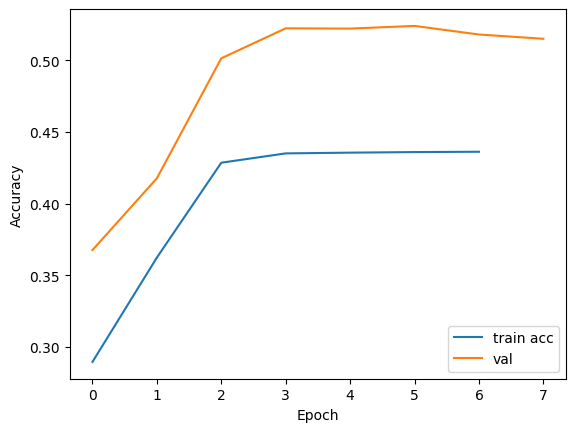

In [275]:
# Accuracy
plt.plot(history.history['accuracy'][1:], label='train acc')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

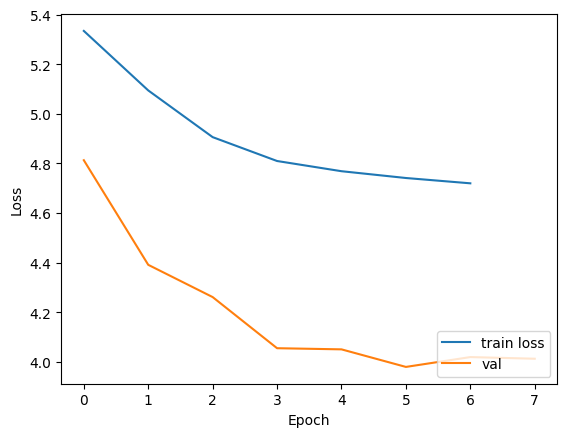

In [276]:
# Loss
plt.plot(history.history['loss'][1:], label='train loss')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

## INFERENCE

In [277]:
# Next, let’s build the dictionary to convert the index to word for target and source vocabulary:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [278]:
def build_seq2seq_model_with_just_lstm_inference(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_lstm
):
    # Encode the input sequence to get the feature vector
    encoder_model = Model(
        inputs=encoder_input, outputs=[encoder_output] + encoder_final_states
    )

    # Decoder setup
    # Below tensors will hold the states of the previous time step
    decoder_state_input_h = Input(shape=(latent_dim, ))
    decoder_state_input_c = Input(shape=(latent_dim, ))
    decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

    # Get the embeddings of the decoder sequence
    decoder_embedding = decoder_embedding_layer(decoder_input)

    # To predict the next word in the sequence, set the initial
    # states to the states from the previous time step
    decoder_output, *decoder_states = last_decoder_lstm(
        decoder_embedding,
        initial_state=[decoder_state_input_h, decoder_state_input_c]
    )

    # A dense softmax layer to generate prob dist. over the target vocabulary
    decoder_output = decoder_dense(decoder_output)

    # Final decoder model
    decoder_model = Model(
        [decoder_input] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c], 
        [decoder_output] + decoder_states
    )

    return (encoder_model, decoder_model)

In [279]:
encoder_model, decoder_model = build_seq2seq_model_with_just_lstm_inference(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_lstm
)

In [280]:
encoder_model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 42)]              0         
                                                                 
 embedding_8 (Embedding)     (None, 42, 300)           5844900   
                                                                 
 lstm_12 (LSTM)              [(None, 42, 240),         519360    
                              (None, 240),                       
                              (None, 240)]                       
                                                                 
 lstm_13 (LSTM)              [(None, 42, 240),         461760    
                              (None, 240),                       
                              (None, 240)]                       
                                                                 
Total params: 6,826,020
Trainable params: 981,120
Non-train

In [281]:
decoder_model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 embedding_9 (Embedding)        (None, None, 300)    2454900     ['input_16[0][0]']               
                                                                                                  
 input_17 (InputLayer)          [(None, 240)]        0           []                               
                                                                                                  
 input_18 (InputLayer)          [(None, 240)]        0           []                               
                                                                                           

In [282]:
decoder_model.layers[-3].input

[<KerasTensor: shape=(None, None, 300) dtype=float32 (created by layer 'embedding_9')>,
 <KerasTensor: shape=(None, 240) dtype=float32 (created by layer 'lstm_13')>,
 <KerasTensor: shape=(None, 240) dtype=float32 (created by layer 'lstm_13')>]

In [283]:
def decode_sequence_seq2seq_model_with_just_lstm(
    input_sequence, encoder_model, decoder_model
):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_sequence)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index[start_token]

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + [e_out, e_h, e_c]
        )

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index+1]

        if sampled_token != end_token:
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == end_token) or (len(decoded_sentence.split()) >= (max_summary_len - 1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [284]:
def seq2summary(input_sequence):
    new_string = ''
    for i in input_sequence:
        if (
            (i != 0 and i != target_word_index[start_token]) and
            (i != target_word_index[end_token])
        ):
            new_string = new_string + reverse_target_word_index[i] + ' '
    return new_string


def seq2text(input_sequence):
    new_string = ''
    for i in input_sequence:
        if i != 0:
            new_string = new_string + reverse_source_word_index[i] + ' '
    return new_string

In [285]:
l = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

if len(l) % 3 != 0:
    while len(l) % 3 != 0:
        l.append(0)
print(l)

lst_i = 3
for i in range(0, len(l), 3):
    print(l[i:i + lst_i])


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 0, 0]
[1, 2, 3]
[4, 5, 6]
[7, 8, 9]
[10, 0, 0]


In [286]:
def predict_text(text, decode_sequence, encoder_model, decoder_model):
    original_text = text
    text = clean_text([text])  # generator
    text_list = original_text.split()

    if len(text_list) <= max_text_len:
        text = expand_contractions(text)
        text = clean_text(text)
        text = f'_START_ {text} _END_'
        text = f'{start_token} {text} {end_token}'

        seq = x_tokenizer.texts_to_sequences([' '.join(text_list)])
        padded = pad_sequences(seq, maxlen=max_text_len, padding='post')
        pred_summary = decode_sequence(
            padded.reshape(1, max_text_len), encoder_model, decoder_model
        )
        return pred_summary
    else:
        pred_summary = ''

        # breaking long texts to individual max_text_len texts and predicting on them
        while len(text_list) % max_text_len == 0:
            text_list.append('')

        lst_i = max_text_len
        for i in range(0, len(text_list), max_text_len):
            _text_list = original_text.split()[i:i + lst_i]
            _text = ' '.join(_text_list)
            _text = ' '.join(
                _text.split()
            )  # to remove spaces that were added to make len(text_list) % max_text_len == 0

            _text = expand_contractions(_text)
            _text = clean_text(_text)  # generator
            _text = f'_START_ {_text} _END_'
            _text = f'{start_token} {_text} {end_token}'

            _seq = x_tokenizer.texts_to_sequences([_text])
            _padded = pad_sequences(_seq, maxlen=max_text_len, padding='post')
            _pred = decode_sequence(
                _padded.reshape(1, max_text_len), encoder_model, decoder_model
            )
            pred_summary += ' ' + ' '.join(_pred.split()[1:-2])
            pred_summary = ' '.join(pred_summary.split())

        return pred_summary

## PREDICTIONS

In [287]:
# Testing on training data
for i in range(0, 4):
    print(f"# {i+1} News: ", seq2text(x_train_padded[i]))
    print("Original summary: ", seq2summary(y_train_padded[i]))
    print(
        "Predicted summary: ",
        decode_sequence_seq2seq_model_with_just_lstm(
            x_train_padded[i].reshape(1, max_text_len), encoder_model,
            decoder_model
        )
    )
    print()

# 1 News:  veteran actor shakti kapoor said luck stronger factor talent become actor talking days punes film television institute india ftii shakti said naseeruddin shah could make films shakti added thought eleven boys ftii ten better 
Original summary:  start luck stronger factor talent actor says shakti end 
1/1 [==============================] - 0s 31ms/step
Predicted summary:   sostok bjp bjp govt govt start delhi end end end end end

# 2 News:  kerala police arrested father basil kuriyakose principal kings david international school allegedly subjecting yearold boy unnatural sex pastor said molested boy mber night hostel inmates gone vacation yearold priest booked section ipc 
Original summary:  start yrold priest held unnatural sex yrold boy end 
1/1 [==============================] - 0s 61ms/step
Predicted summary:   sostok bjp bjp govt govt start delhi end end end end end

# 3 News:  opposition staged walkout maharashtra assthembly dthemanding probe allegations rape woman mini

In [291]:
# Testing on validation data
for i in range(0, 4):
    pred_sum = decode_sequence_seq2seq_model_with_just_lstm(
            x_val_padded[i].reshape(1, max_text_len), encoder_model,
            decoder_model
        )
    actual_sum = seq2summary(y_val_padded[i])
    print(f"# {i+1} News: ", seq2text(x_val_padded[i]))
    print("Original summary: ", actual_sum)
    print("Predicted summary: ",pred_sum)
    
    rouge_1, rouge_2, rouge_l = calculate_rouge_score(actual_sum, pred_sum)
    print("ROUGE-1:", rouge_1)
    print("ROUGE-2:", rouge_2)
    print("ROUGE-L:", rouge_l)
    
    print()

1/1 [==============================] - 0s 35ms/step
# 1 News:  man arrested delhi airport friday allegedly carrying nearly lakh unauthorised manner senior official said passenger identified rohit ku intercepted cisf personnel baggage check revealed suspicious packet containing five envelopes five envelopes contained 
Original summary:  start man held cash delhi airport end 
Predicted summary:   sostok bjp bjp govt govt start delhi end end end end end
ROUGE-1: 0.4615384565680473
ROUGE-2: 0.0
ROUGE-L: 0.4615384565680473

1/1 [==============================] - 0s 33ms/step
# 2 News:  twenty indian royal families present traditional cuisine part threeday dine royalty event new delhi ber six luxury capable diners represent heritage states also special performances local artistes region 
Original summary:  start indian families present traditional end 
Predicted summary:   sostok bjp bjp govt govt start delhi end end end end end
ROUGE-1: 0.3333333283333334
ROUGE-2: 0.0
ROUGE-L: 0.33333332833

## SAVING THE MODEL

In [289]:
# HDF5 format
model.save('model.h5')
encoder_model.save('encoder_model.h5')
decoder_model.save('decoder_model.h5')